# BiRNN

使用预训练Word2vec，并且每个小批量进行填充

In [1]:
import torch
import os
import sys
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(r'D:\code\Python-Project\文本数据挖掘\WBClassify')))
from WBClassify.Utils import utils,vocab,Trie
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
import random 

In [2]:
def seed_torch(seed=42):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True

seed_torch()

In [3]:

def collate_fn(data):               # 传入的数据，对数据的输出形式进行设定
    inputs = [torch.tensor(i[0]) for i in data]
    lengths = torch.tensor([len(i[0]) for i in data])
    targets = torch.tensor([i[1] for i in data], dtype=torch.long)
    # 对batch内的样本进行padding，使其具有相同长度
    inputs = pad_sequence(inputs, batch_first=True)
    return inputs, lengths, targets

train_data_loader,test_data_loader,vocab_,encoder = utils.load_data(batch_size=64,is_truncate_pad=False,collate_fn=collate_fn,
                                                                    is_gotchinese=False,is_dropword=True,method='jieba')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.596 seconds.
Prefix dict has been built successfully.


In [4]:
for x,y,z in train_data_loader:
    print(x.shape)
    print(y)
    print(z)
    break

torch.Size([64, 17])
tensor([11, 10,  9,  7, 14,  4,  9,  8, 11,  7, 13, 13, 17, 10,  6, 12, 10, 13,
         8, 14, 10, 15,  7, 11,  9,  7,  9,  7,  9, 12, 10,  5,  9,  5,  9, 13,
        13, 14,  6, 11,  9,  8, 13,  5, 12, 13, 12,  4,  8, 12, 10, 10, 10, 12,
        12,  8,  8, 15,  6, 10, 11, 12,  8, 11])
tensor([1, 3, 2, 1, 4, 0, 1, 2, 0, 1, 0, 0, 4, 1, 1, 0, 0, 4, 2, 4, 2, 4, 1, 3,
        3, 1, 2, 1, 2, 3, 2, 1, 1, 3, 3, 3, 3, 4, 1, 3, 3, 1, 2, 2, 4, 2, 1, 2,
        2, 1, 1, 0, 4, 2, 0, 2, 0, 4, 0, 1, 3, 3, 1, 4])


In [5]:

from torch.nn.modules import batchnorm

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class):
        super(LSTM, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)                   # 词向量
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2,batch_first=True,bidirectional=True)            # LSTM
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, 300*4),                              # 线性输出层
            nn.Dropout(0.2),
            nn.Linear(1200,512),
            nn.Linear(512,num_class)
        )

    def forward(self, inputs, lengths):
        embeddings = self.embeddings(inputs)    
        x_pack = pack_padded_sequence(embeddings, lengths.to('cpu'), batch_first=True, enforce_sorted=False)            # length要放到cpu上
        hidden, (hn, cn) = self.lstm(x_pack)
        outputs = self.output(hn[-1])
        # log_probs = F.log_softmax(outputs, dim=-1)
        return outputs
    

embedding_dim = 300
hidden_dim = 300
num_class = len(encoder.classes_)

In [6]:
model = LSTM(len(vocab_), embedding_dim, hidden_dim, num_class)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
                
model.apply(init_weights)

LSTM(
  (embeddings): Embedding(15653, 300)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, bidirectional=True)
  (output): Sequential(
    (0): Linear(in_features=300, out_features=1200, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1200, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [7]:
import hanlp
embeds = utils.TokenEmbedding(vocab_.idx_to_token)
embeds.shape

torch.Size([15653, 300])

In [8]:
model.embeddings.weight.data.copy_(embeds)
model.embeddings.weight.requires_grad = False

-----------------------------------------------------------------
| epoch  0 | avg_loss:5.959 | train_acc:0.23 |
| epoch  0 | avg_loss:4.267 | train_acc:0.29 |
| epoch  0 | avg_loss:3.320 | train_acc:0.34 |
| epoch  0 | avg_loss:2.744 | train_acc:0.40 |
| epoch  0 | avg_loss:2.351 | train_acc:0.46 |
| epoch  0 | avg_loss:2.289 | train_acc:0.47 |
-----------------------------------------------------------------
| epoch  0 | avg_loss:2.289 | train_acc:0.47 | test_acc:0.73| lr:0.01 | 
-----------------------------------------------------------------
| epoch  1 | avg_loss:0.583 | train_acc:0.78 |
| epoch  1 | avg_loss:0.606 | train_acc:0.78 |
| epoch  1 | avg_loss:0.595 | train_acc:0.78 |
| epoch  1 | avg_loss:0.602 | train_acc:0.78 |
| epoch  1 | avg_loss:0.607 | train_acc:0.78 |
| epoch  1 | avg_loss:0.608 | train_acc:0.79 |
-----------------------------------------------------------------
| epoch  1 | avg_loss:0.608 | train_acc:0.79 | test_acc:0.78| lr:0.01 | 
--------------------------

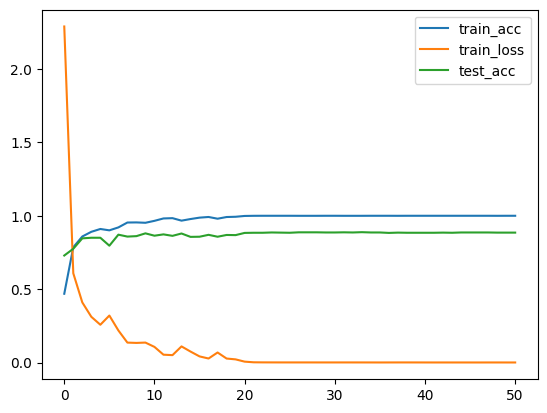

In [9]:
loss = nn.CrossEntropyLoss(reduction='none')           # 反向传播对每个分量进行求导，此处设置reduce='none'，该损失函数及自己计算softmax
optimizer = optim.Adam(model.parameters(), lr=0.01)    # 使用Adam优化器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)       # warm up
num_epoch = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
utils.train_with_length(model,train_data_loader,test_data_loader,loss,optimizer,num_epoch,device,scheduler=scheduler)